In [1]:
# System libraries
import random
import re
import unicodedata
import itertools

# File manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab as pl
import plotly.express as px
from wordcloud import WordCloud

# Model transformers and preprocessing
import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from keras.preprocessing.sequence import pad_sequences

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())


Python version in this Jupyter Notebook: 3.11.3


In [2]:
# Load library versions
from watermark import watermark
%reload_ext watermark
%watermark -a "Library versions" --iversions


Author: Library versions

seaborn     : 0.12.2
plotly      : 5.9.0
watermark   : 2.5.0
numpy       : 1.24.3
pandas      : 1.5.3
platform    : 1.0.8
matplotlib  : 3.7.1
re          : 2.2.1
torch       : 2.5.1
keras       : 2.13.1
transformers: 4.47.0
wordcloud   : 1.9.4



In [3]:
# Load training and testing datasets
train_df = pd.read_csv(r"Kaggle\llm-classification-finetuning\train.csv")
test_df = pd.read_csv(r"Kaggle\llm-classification-finetuning\test.csv")

# View dataset
display(train_df.head(), train_df.tail(), train_df.shape)
train_df.info()


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0
57476,4294947231,gemini-pro-dev-api,gpt-4-1106-preview,"[""three kids eat three apples in three days, h...","[""27 apples""]","[""If three kids eat three apples in three days...",1,0,0


(57477, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [4]:
# Combine text columns
train_df['combined_text'] = train_df['prompt'] + " [SEP] " + train_df['response_a'] + " [SEP] " + train_df['response_b']
test_df['combined_text'] = test_df['prompt'] + "[SEP]" + test_df['response_a'] + "[SEP]" + test_df['response_b']

# Create labels
train_df['label'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1)

# Map labels to integers
label_mapping = {'winner_model_a': 0, 'winner_model_b': 1, 'winner_tie': 2}
train_df['label'] = train_df['label'].map(label_mapping)


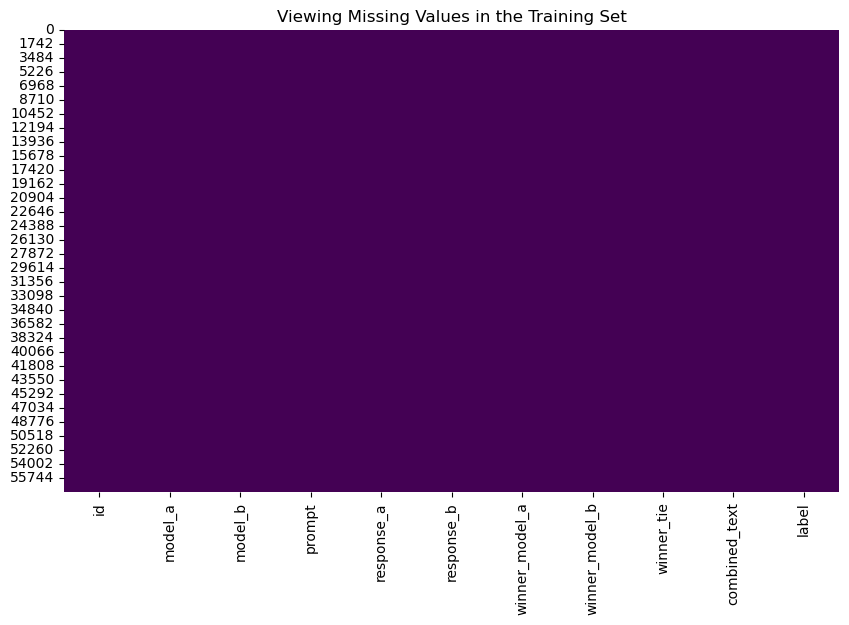

Number of missing values ​​per column:
id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
combined_text     0
label             0
dtype: int64


In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Viewing Missing Values in the Training Set")
plt.show()

print("Number of missing values ​​per column:")
print(train_df.isnull().sum())


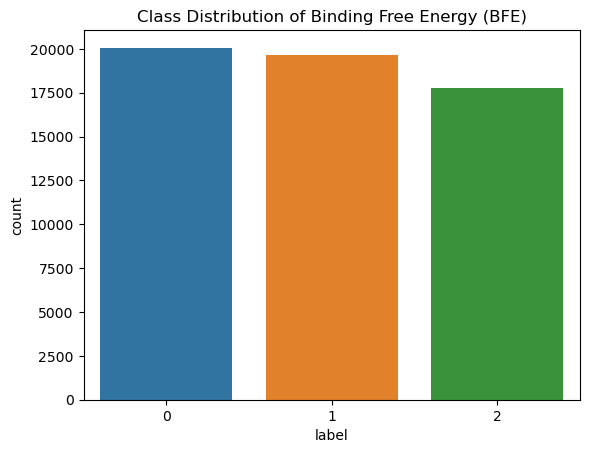


Class Distribution:
0    20064
1    19652
2    17761
Name: label, dtype: int64


In [6]:
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution of Binding Free Energy (BFE)")
plt.grid(False)
plt.show()

print("\nClass Distribution:")
print(train_df['label'].value_counts())


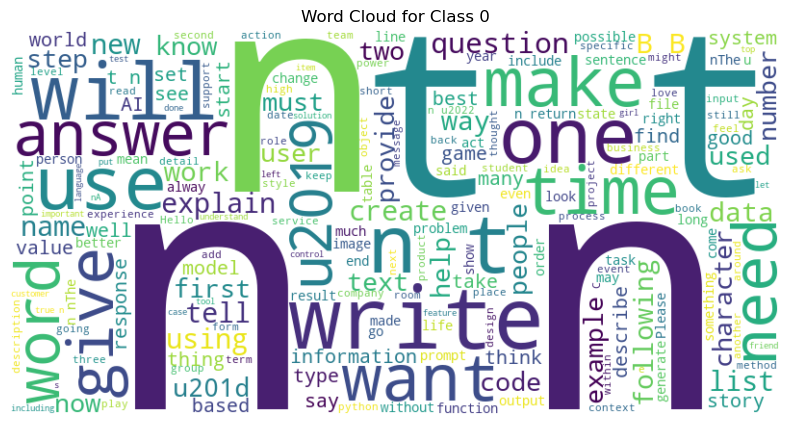

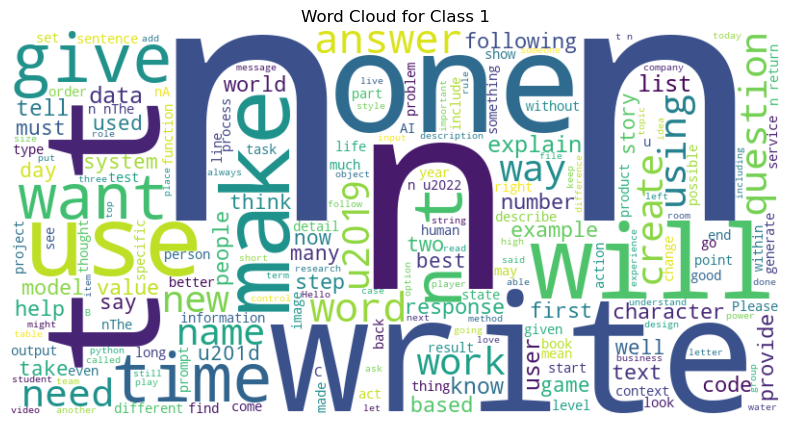

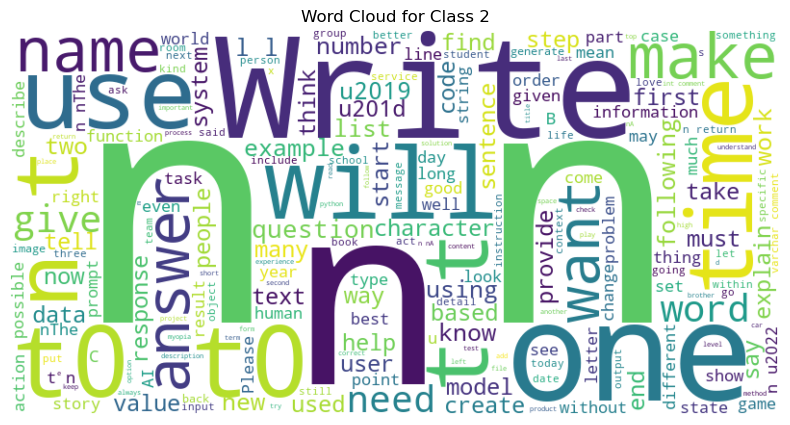

In [7]:
# Generate word clouds for each class
labels = train_df['label'].unique()

for label in labels:
    textos_prompt = ' '.join(train_df[train_df['label'] == label]['prompt'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_prompt)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Class {label}')
    plt.show()


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Initialize TfidfVectorizers for each column
vectorizer_prompt = TfidfVectorizer(max_features=500)
vectorizer_resp_a = TfidfVectorizer(max_features=500)
vectorizer_resp_b = TfidfVectorizer(max_features=500)

# Train data transformation
train_prompt_features = vectorizer_prompt.fit_transform(train_df['prompt'])
train_resp_a_features = vectorizer_resp_a.fit_transform(train_df['response_a'])
train_resp_b_features = vectorizer_resp_b.fit_transform(train_df['response_b'])
train_combined_features = hstack([train_prompt_features, train_resp_a_features, train_resp_b_features])

# Test data transformation
test_prompt_features = vectorizer_prompt.transform(test_df['prompt'])
test_resp_a_features = vectorizer_resp_a.transform(test_df['response_a'])
test_resp_b_features = vectorizer_resp_b.transform(test_df['response_b'])
test_combined_features = hstack([test_prompt_features, test_resp_a_features, test_resp_b_features])


In [9]:
from sklearn.model_selection import train_test_split

X = train_combined_features
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)


Training data shape: (45981, 1500)
Validation data shape: (11496, 1500)


In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# LightGBM parameters
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': -1,
    'num_leaves': 31,
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'random_state': 42
}

# Initialize model
model = LGBMClassifier(**lgbm_params)

# Train model
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351844
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 1499
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353


LGBMClassifier(learning_rate=0.05, n_estimators=500, num_class=3,
               objective='multiclass', random_state=42)

In [11]:
# Predictions and evaluation
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.45781141266527486
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.52      0.49      4013
           1       0.46      0.50      0.48      3931
           2       0.44      0.33      0.38      3552

    accuracy                           0.46     11496
   macro avg       0.46      0.45      0.45     11496
weighted avg       0.46      0.46      0.45     11496



In [12]:
# Save predictions to CSV
output_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_label': y_pred
})

# Save to CSV
output_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
